In [1]:
import numpy as np
import matplotlib.pyplot as plt

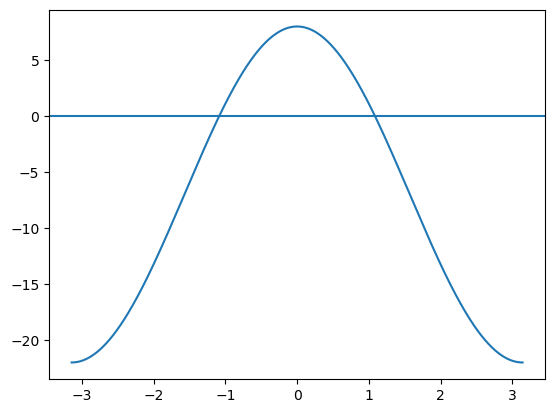

In [5]:
I = -7
IL = 15

theta = np.linspace(-np.pi, np.pi, 1000)
gt = np.cos(theta)

IE = I + IL * gt

plt.plot(theta, IE)
plt.axhline(0)